# Classifying Names with a Character-RNN in PyTorch

Recurrent neural networks (RNN's) are a special class of neural network architectures which loop over sequences. If we thinkg of sequences as containing a time element, then the goal of an RNN is to encode this sequence over time and use it to make predictions. RNN's do this my keeping an internal representation of the sequence at each time step, known as the _memory_.

The main challenge with RNN's is how to make this memory preserve information over long timespans while still ensuring that training is robust and efficient. This research has lead to many interesting types of RNN's architectures with various extensions and features. However in this [tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html), the focus will be on a simple character-level RNN.

The goal will be to classify the origin language of a name, which is treated as a sequence of letters over time. 

```
  (RNN)->(RNN)->(RNN)->(RNN)--> South Africa
    ^    ^    ^    ^    ^
    |    |    |    |    |
    J -> O -> N -> T -> Y 
```

In [1]:
import os
import glob  # unix style pathname pattern matching/expansion
import string
import time
import math
import random
import unicodedata

from io import open

import torch
import torch.nn as nn

import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

HOME = os.environ["AI_HOME"]
ROOT = os.path.join(HOME, "artificial_neural_networks")
DATA = os.path.join(ROOT, "data")
NAMES = os.path.join(DATA, "names")

random.seed(1901)
np.random.seed(1901)
torch.manual_seed(1901)

## Data Preprocessing

Unlike image data which has standard data formats, libraries and dataloaders in PyTorch, text data is far more varied and assembling training and test data in the right format for deep learning often depends on the source data and the problem you're trying to solve. In this tutorial we will process data as follows:

- Walk through files for each language
- Extract names and convert to ASCII characters
- Assign list of names to each language in a dictionary
- Convert names to tensors using a character-level mapping

### Parse Name Files

For this tutorial, the [data](https://download.pytorch.org/tutorial/data.zip) is in the form of text files for each language class, with the filename indicating the class. I've saved the data in a directory called `names`. We can view the different languages in this directory by walking through each file and extracting the filename:

In [2]:
def find_files(path_pattern):
    """Returns a list of files matching the provided path pattern"""
    return glob.glob(path_pattern)

In [3]:
namefiles = find_files(os.path.join(NAMES, 'names', '*.txt'))

for language_file in namefiles:
    file = os.path.basename(language_file)
    language, _ = os.path.splitext(file)
    print(language)

Arabic
Chinese
Czech
Dutch
English
French
German
Greek
Irish
Italian
Japanese
Korean
Polish
Portuguese
Russian
Scottish
Spanish
Vietnamese


### ASCII Encoding

To make training easier we'll restrict characters to ASCII. This reduces dimensionality of the input tensors.

In [4]:
ascii_letters = string.ascii_letters + " .,;'"
n_letters = len(ascii_letters)

In [5]:
def unicode_to_ascii(string_):
    # ref: https://stackoverflow.com/a/518232/2809427
    return ''.join(
        char for char in unicodedata.normalize('NFD', string_)  # Unicode normal form decomposition of character
        if unicodedata.category(char) != 'Mn'  # non-spacing mark characters
        and char in ascii_letters)  # keep only ascii letters

In [6]:
print(unicode_to_ascii('Ślusàrski'))

Slusarski


### Parse Names

Each name is a single line in each language file. We'll parse names by reading the file line-by-line.

In [7]:
def parse_names(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')  # list of lines
    return [unicode_to_ascii(name) for name in lines]

In [8]:
print(parse_names(os.path.join(NAMES, 'names', 'Arabic.txt'))[:5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


### Organise Names

Here we will organise the names for each language in a dictionary container.

In [9]:
language_names = {}
language_classes = []

for filename in find_files(os.path.join(NAMES, 'names', '*.txt')):
    names = parse_names(filename)
    language, _ = os.path.splitext(os.path.basename(filename))
    language_classes.append(language)
    language_names[language] = names
    
n_classes = len(language_classes)

In [10]:
print(language_names['Scottish'][:5])

['Smith', 'Brown', 'Wilson', 'Campbell', 'Stewart']


### Convert Names to Tensors

The following helper functions will convert names to tensors using the list index of each character in the `ascii_letters` list created earlier. Once we have that we can create onehot vectors for each letter and then finally we can do this for an entire name.

In [11]:
def letter2index(letter):
    return ascii_letters.find(letter)

def letter2tensor(letter):
    tensor = torch.zeros(1, n_letters) # 1 x n_letters tensor
    tensor[0][letter2index(letter)] = 1  # encode "hot" 1 at letter's index
    return tensor

def name2tensor(name):
    seq_len = len(name)
    tensor = torch.zeros(seq_len, 1, n_letters) # seq_len x 1 x n_letters tensor <-> seq_len x {onehot_tensors}
    for idx, letter in enumerate(name):
        tensor[idx][0][letter2index(letter)] = 1
    return tensor

In [12]:
print(letter2tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [13]:
print(name2tensor('Jonty'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [14]:
print(name2tensor('Jonty').size())

torch.Size([5, 1, 57])


## Recurrent Neural Network

Although PyTorch already contains optimised recurrent neural network modules, for the sake of learning we'll implement an RNN from scratch using base PyTorch `nn` modules, using the following control flow:

<img src="assets/rnn.png">

In [15]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        self.out_gate = nn.Linear(input_size + hidden_size, output_size)  #i2o in the diagram
        self.memory_gate = nn.Linear(input_size + hidden_size, hidden_size)  #i2h in the diagram
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)  # concat input seq with hidden state
        
        hidden = self.memory_gate(combined)
        
        output = self.out_gate(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)  # in an RNN we also need to initialise the memory
    

In [16]:
n_hidden = 128

rnn = RNN(input_size=n_letters, hidden_size=n_hidden, output_size=n_classes)
print(rnn)

RNN(
  (out_gate): Linear(in_features=185, out_features=18, bias=True)
  (memory_gate): Linear(in_features=185, out_features=128, bias=True)
  (softmax): LogSoftmax()
)


In principle we apply this RNN to each character in a name (as a sequence of characters)

In [17]:
input_ = letter2tensor('J')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_, hidden)

print("Output size: ", output.size())
print("Hidden size: ", next_hidden.size())

Output size:  torch.Size([1, 18])
Hidden size:  torch.Size([1, 128])


However for the sake of efficiency we will convert the entire name to the tensor and pass each character as a slice of this tensor:

In [18]:
input_ = name2tensor('Jonty')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_[0], hidden)
print("Output size: ", output.size())
print("Hidden size: ", next_hidden.size())

Output size:  torch.Size([1, 18])
Hidden size:  torch.Size([1, 128])


In [19]:
print(output)

tensor([[-2.8581, -2.9214, -2.8579, -2.8422, -2.9206, -2.8311, -2.8924, -2.8813,
         -2.8951, -2.9975, -2.8237, -2.9043, -2.9316, -2.8723, -2.9691, -2.8691,
         -2.9062, -2.8705]], grad_fn=<LogSoftmaxBackward>)


The output is a _softmax categorical distribution_ over the language class. During training we'll optimise the probabilies, given the input. We'll use the following helper function to indicate which language the RNN thinks is most probable:

In [20]:
def predict_language(output):
    top_n, top_i = output.topk(1)
    max_idx = top_i[0].item()
    return language_classes[max_idx], max_idx

In [21]:
predict_language(output)

('Japanese', 10)

## Training

Next we would like to train the RNN. We would like to train the RNN in batches over several epochs. To do so we will need to create a batch generator over the training data.

In [22]:
def random_choice(list_):
    return list_[random.randint(0, len(list_) - 1)]

def random_training_example():
    language = random_choice(language_classes)
    name = random_choice(language_names[language])
    language_tensor = torch.tensor([language_classes.index(language)], dtype=torch.long)  # index of language
    name_tensor = name2tensor(name)
    
    return language, name, language_tensor, name_tensor

In [23]:
for _ in range(10):
    language, name, language_tensor, name_tensor = random_training_example()
    print(f'({name}, {language})')

(Bonaventura, Spanish)
(Sugitani, Japanese)
(Velgus, Russian)
(Woo, Korean)
(Nifterik, Dutch)
(Ganim, Arabic)
(Murphy, Irish)
(Quinton, English)
(Yin, Chinese)
(Teague, Irish)


To train the RNN we need to go through each name (iterate through the data) and over each character in the name (iterate through time). The optimisation step is applied over all characters to each name and is known as _backpropagation through time_. We'll use a timer function to keep track of training time.

In [24]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [25]:
log_likelihood = nn.NLLLoss()
optimiser = optim.SGD(rnn.parameters(), lr = 0.005)

In [26]:
def backprop_through_time(name_tensor, language_tensor):
    hidden = rnn.init_hidden()
    
    rnn.zero_grad()
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    
    loss = log_likelihood(output, language_tensor)
    loss.backward()
    optimiser.step()
    
    return output, loss.item()

In [27]:
def train(num_iters, print_every, plot_every):
    
    current_loss = 0.0
    all_losses = []
    
    start = time.time()
    
    for iter_ in range(1, num_iters + 1):
        language, name, language_tensor, name_tensor = random_training_example()
        output, loss = backprop_through_time(name_tensor, language_tensor)
        current_loss += loss
        
        # Print iteration number, loss, name and guess
        if iter_ % print_every == 0:
            guess, _ = predict_language(output)
            correct = '✓' if guess == language else '✗ (%s)' % language
            print('%d %d%% (%s) %.4f %s / %s %s' % (
                iter_, iter_ / num_iters * 100, timeSince(start), loss, name, guess, correct))

        # Add current loss avg to list of losses
        if iter_ % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            
    return all_losses

In [28]:
all_losses = train(num_iters=100000, print_every=5000, plot_every=1000)

5000 5% (0m 6s) 2.6313 Macghabhann / Scottish ✗ (Irish)
10000 10% (0m 13s) 2.3983 Travers / Portuguese ✗ (French)
15000 15% (0m 20s) 2.1819 V'Yugin / Irish ✗ (Russian)
20000 20% (0m 27s) 2.0035 Ahearn / Dutch ✗ (Irish)
25000 25% (0m 34s) 1.3481 Chew / Korean ✗ (Chinese)
30000 30% (0m 41s) 1.9320 Traversa / Spanish ✗ (Italian)
35000 35% (0m 48s) 0.0535 O'Donnell / Irish ✓
40000 40% (0m 55s) 0.2347 Porohovschikov / Russian ✓
45000 45% (1m 1s) 0.1808 Sfakianos / Greek ✓
50000 50% (1m 8s) 1.4721 Reid / Scottish ✓
55000 55% (1m 14s) 0.3227 Wegener / German ✓
60000 60% (1m 21s) 2.2450 Pawson / Scottish ✗ (English)
65000 65% (1m 27s) 0.9304 Ibarra / Spanish ✓
70000 70% (1m 33s) 0.3597 Rim / Korean ✓
75000 75% (1m 40s) 1.2124 Ngai / Korean ✓
80000 80% (1m 47s) 0.1502 Avetisov / Russian ✓
85000 85% (1m 54s) 0.7546 Teoh / Chinese ✓
90000 90% (2m 1s) 1.8436 Altamura / Spanish ✗ (Italian)
95000 95% (2m 8s) 1.2984 Bisset / French ✓
100000 100% (2m 16s) 0.7675 Barros / Portuguese ✓


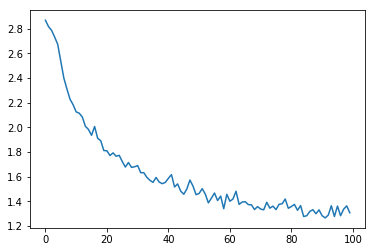

In [29]:
plt.figure()
plt.plot(all_losses)

## Evaluation

Finally we will see how well our model performed on different categories by creating a confusion matrix where rows represent the actual language and columns the predicted. The intensity of the colours will indicate how many times a model predicted a name from language i as coming from language j.

### RNN Prediction

To make predictions using the RNN we run every character in the input through the cell and use the final output to make the prediction. We can think of the RNN as refining its guess with each new character.

In [34]:
def predict(name_tensor):
    with torch.no_grad():
        hidden = rnn.init_hidden()

        for i in range(name_tensor.size()[0]):
            output, hidden = rnn(name_tensor[i], hidden)
        
        return output

In [35]:
def evaluate_confusion(num_eval_samples):
    confusion = torch.zeros(n_classes, n_classes)
    
    for i in range(num_eval_samples):
        # groundtruth
        language, name, language_tensor, name_tensor = random_training_example()
        language_idx = language_classes.index(language)
        # prediction
        output = predict(name_tensor)
        guess, guess_idx = predict_language(output)
        
        confusion[language_idx][guess_idx] += 1
        
    # normalize every row
    for i in range(n_classes):
        confusion[i] = confusion[i] / confusion[i].sum()
        
    return confusion

In [38]:
def plot_confusion(confusion):
    
    # set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # set up axes
    ax.set_xticklabels([''] + language_classes, rotation=90)
    ax.set_yticklabels([''] + language_classes)

    # force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [39]:
confusion = evaluate_confusion(num_eval_samples=10000)

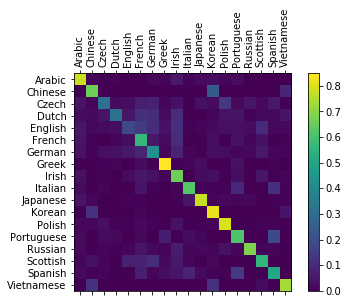

In [40]:
plot_confusion(confusion)